In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

## 1D Fourier Neural Network for Black-Scholes Model
Inputs: Boundary conditions C(S,T) = max(S-K,0). 2048 realizations for random $K \in [0,1]$ and 8196 grid points for $S \in [0.1,1]$

Outputs: European Call option prices from BS model at $t=0$

$\sigma = 0.2, r =0.05$

Data generated in data_generation/BS



In [5]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):

        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.elu(x)
        x = self.fc2(x)
        return x

################################################################
#  configurations
################################################################
ntrain = 1800
ntest = 200

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 16
width = 64


In [6]:
################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = MatReader('data/BS_data1.mat')
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

# cat the locations information
grid = np.linspace(0.1, 1, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
print(count_params(model))


287425


In [7]:


################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        # mse.backward()
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

# torch.save(model, 'model/ns_fourier_burgers')
pred = torch.zeros(y_test.shape)
benchmark = torch.zeros(y_test.shape)
inputs = torch.zeros(x_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x)
        pred[index] = out.squeeze()
        benchmark[index] = y.squeeze()
        inputs[index] = x

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

    scipy.io.savemat('pred/BS_test.mat', mdict={'pred': pred.cpu().numpy()})
    scipy.io.savemat('pred/BS_benchmark.mat', mdict={'benchmark': benchmark.cpu().numpy()})
    scipy.io.savemat('pred/BS_inputs.mat', mdict={'inputs': inputs.cpu().numpy()})

0 3.411233599999999 0.023711757546213144 0.4089742541975445 0.12994380593299865
1 0.6087751999999966 0.00029307424685814313 0.08207229067881902 0.053857113122940066
2 0.6263767999999956 0.00034139937108395516 0.07889139397276772 0.061030308306217196
3 0.6207081000000017 0.00011203305010793782 0.05420884983407127 0.026236137747764586
4 0.6456890000000044 0.0001785728522008867 0.052640970200300216 0.12619728088378906
5 0.7583484000000027 0.00029366401261844054 0.06266131401062011 0.03175717622041702
6 0.6138991999999988 8.407583793288925e-05 0.046207417415248024 0.04142301172018051
7 0.6271581000000026 0.00013779057446501814 0.042805115150080786 0.04356396824121475
8 0.6404578999999941 0.00010351760010962607 0.043423055294487214 0.03946750611066818
9 0.6374698999999993 8.969920798133697e-05 0.03950349950128131 0.030255648344755172
10 0.6279067999999981 6.181586510744334e-05 0.03667265794343418 0.023692546784877776
11 0.6172526000000005 6.725694619389187e-05 0.03436527960830264 0.02282194

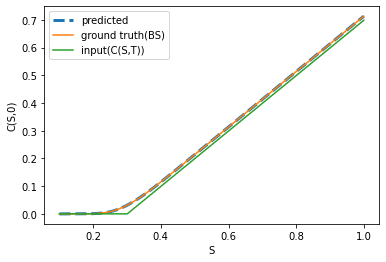

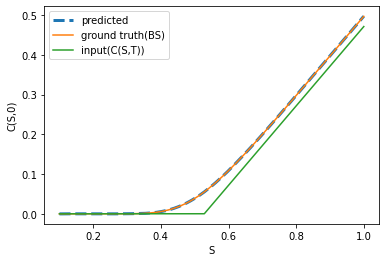

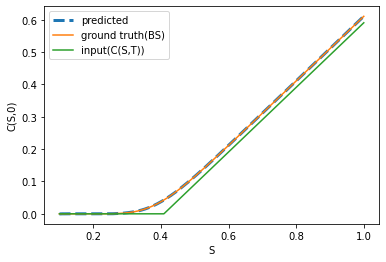

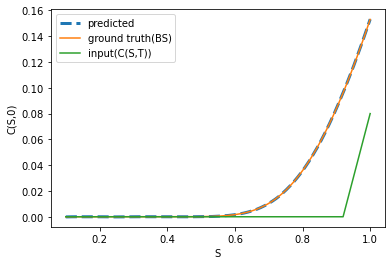

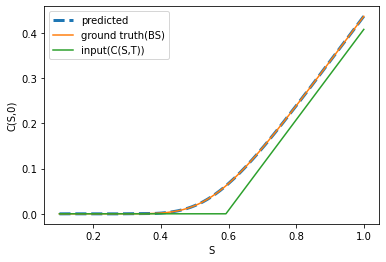

In [8]:
pred = scipy.io.loadmat('pred/BS_test.mat')
pred = pred['pred']

inputs = scipy.io.loadmat('pred/BS_inputs.mat')
inputs = inputs['inputs']

benchmark = scipy.io.loadmat('pred/BS_benchmark.mat')
benchmark = benchmark['benchmark']

xx = inputs[1,:,1]

for k in range(1,10,2):
    plt.figure()
    plt.plot(xx,pred[k,:],'--',label = 'predicted',linewidth=3)
    plt.plot(xx,benchmark[k,:],label = 'ground truth(BS)')
    plt.plot(xx,inputs[k,:,0],label='input(C(S,T))')
    plt.xlabel('S')
    plt.ylabel('C(S,0)')
    plt.legend()
    plt.show()



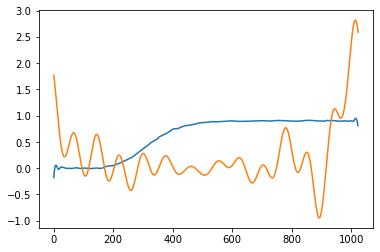

In [16]:
from torch import Tensor
from torch.autograd import Variable
from torch.autograd import grad
from torch import nn
import torch
torch.cuda.empty_cache()
Zst = x_test[1:10,:,:].cuda()
Zst.requires_grad = True
testderiv= grad(model.forward(Zst).sum(), Zst, create_graph = True, allow_unused= True)[0]


case = 5
plt.plot((pred[case,1:]-pred[case,:-1])/(1./1024))
plt.plot(testderiv[case][:,0].detach().cpu().numpy())

